# Module 04: Assignment for 2-Dimensional Landscape Evolution Model

## Overview and Requirements

In this assignment you will examine the long term behavior of the elevation field under two different assumptions about the landscape diffusivity (i.e., the variable controlling soil creep). Use the code below to conduct the following experiments:

__Experiment 1:__ Using the code below conduct an experiment that leaves everything unchanged, except `tf` which you should increase to 100,000 yrs and increasing the plotting output interval (`OutputInterval`) to 20,000 years. Run the model and also create an array that is `Nt` in length to store the maximum elevation in the 2-D domain at each time step. You will need to use the `.max` function on `hnext` to obtain this inside the main `for` loop of the model.

__Experiment 2:__ Using the same setup as you did for Experiment 1 above, now _decrease_ the diffusivity `D` by an order of magnitude and re-run the model, again keeping track of the maximum elevation in the domain at each modeling time step.

The notebook you turn in should have the following plots:
* The maximum elevation versus time for both experiments on the same plot
* The 3D plot containing topographic surfaces at every 20,000 year interval for __Experiment 1__ (clearly labelled)
* The 3D plot containing topographic surfaces at every 20,000 year interval for __Experiment 2__ (clearly labelled)

Answer the following question:
* How does changing the diffusivity change the evolution of the maximum elevation in each experiment?
* If we were to allow Experiments 1 and 2 to run for an infinite amount of time, how would the topographic surface between the experiments? What would be the only difference between the two topographies?

In [1]:
import numpy as np
import matplotlib.pyplot as plt

hi = 100.0 # (m)
D = 2.5 # (m^2/yr)

ti = 0.0 # (yr)
tf = 100000.0 # (yr)
dt = 5 # (yr)

# Uplift rate (m/yr)
U = 0.005 # (m/yr)

# Plotting options
individual_plots = 1 # If 1, individual plot at every output interval, all stacked otherwise
OutputInterval = 20000.0 # (yr)

Nt = (tf - ti)/dt + 1

Noutput = (tf - ti)/OutputInterval + 1

xMax = yMax = 500.0
xMin = yMin = 0.0
Nx = Ny = 50

x = np.linspace(xMin,xMax,Nx)
y = np.linspace(yMin,yMax,Ny)

dx = x[1] - x[0]
dy = y[1] - y[0]

X, Y = np.meshgrid(x,y)

In [45]:
# TEST STATEMENT
print(Nt)

20001.0


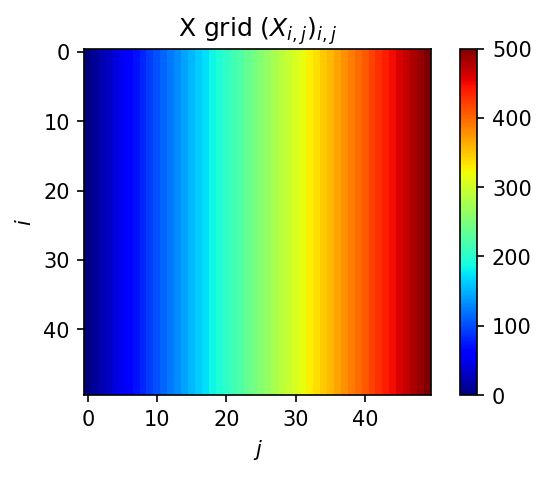

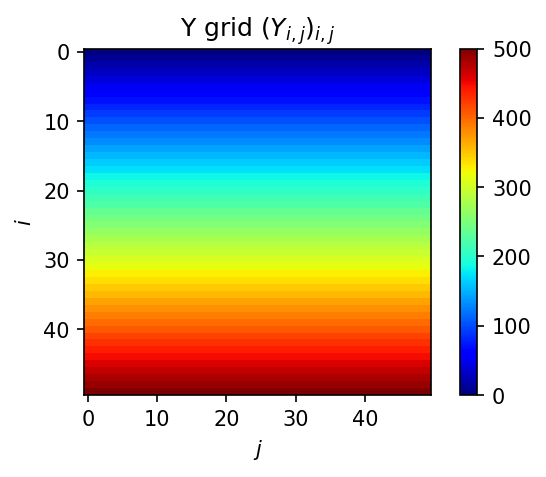

In [3]:
# TEST STATEMENT
# Plot X grid
plt.figure(1,figsize=(5,3), dpi=150)
plt.title("X grid $(X_{i,j})_{i,j}$")
plt.xlabel(r"$j$")
plt.ylabel(r"$i$")
plt.imshow(X,cmap="jet")
plt.colorbar()
plt.show()

# Plot Y grid
plt.figure(2,figsize=(5,3), dpi=150)
plt.title("Y grid $(Y_{i,j})_{i,j}$")
plt.xlabel(r"$j$")
plt.ylabel(r"$i$")
plt.imshow(Y,cmap="jet")
plt.colorbar()
plt.show()

## Compute the Stability Variable

In [4]:
alpha = D*dt/dx**2
print("alpha = ",alpha)
print("dt = ",dt)
print("dx = ",dx)
if alpha >= 0.5:
    raise Exception("Stability criteria error! Either decrease dt or increase dx!")

alpha =  0.12005000000000002
dt =  5
dx =  10.204081632653061


## Setup the Solver Matrix

In [5]:
N = Nx*Ny

ind = np.linspace(0,N-1,N)
Ind = np.linspace(0,N-1,N).reshape((Ny,Nx))

Delta2 = np.matrix(np.diagflat(-4.0*np.ones((int(N),1)),k=0) + np.diagflat(np.ones((int(N-1),1)),k=1) \
    + np.diagflat(np.ones((int(N-1),1)),k=-1) + np.diagflat(np.ones((int(N-Nx),1)),k=int(Nx)) \
    + np.diagflat(np.ones((int(N-Ny),1)),k=-(int(Ny))))

# TEST STATEMENT
'''
plt.figure(3,figsize=(6,4), dpi=150)
plt.title("Incidence matrix")
plt.imshow(Delta2[0:(2*int(Ny)),0:(2*int(Nx))],cmap="seismic")
plt.colorbar()
plt.show()
'''

'\nplt.figure(3,figsize=(6,4), dpi=150)\nplt.title("Incidence matrix")\nplt.imshow(Delta2[0:(2*int(Ny)),0:(2*int(Nx))],cmap="seismic")\nplt.colorbar()\nplt.show()\n'

## Setup the Boundary Conditions

In this problem, the boundary conditions are a little more complex. We will assume that the elevation at the corder of our square domain remain fixed throughout the simulation. But the rest of the area along the edges of the domain can evolve.

What we need to do to allow this is actually first solve the 1-D problem once (using the same $\Delta x$, $D$, $\Delta t$, and simulation duration) on the edges of the domain with fixed edges, and then use that solution at every time step along ___all four___ edges of the domain.

In [8]:
NBound = np.array(Ind[0,:])
SBound = np.array(Ind[-1,:])
WBound = np.array(Ind[:,0])
EBound = np.array(Ind[:,-1])

# Now compute the boundary conditions on the sides of the domain as the temporal evolution of a !D
# profile in response to a lowering of head on 1-side of the domain

Delta2_1D = np.matrix(np.diagflat(-2.0*np.ones((int(Nx),1)),k=0) + np.diagflat(np.ones((int(Nx-1),1)),k=1) \
    + np.diagflat(np.ones((int(Nx-1),1)),k=-1))

h0_1D = hi*np.ones(shape=(int(Nx),1))

H_1D = np.matrix(np.zeros(shape=(int(Nx),int(Nt))))

H_1D[:,0] = np.matrix(h0_1D)

for i in range(1,int(Nt)):
    hinit_1D = H_1D[:,i-1]

    hnext_1D = hinit_1D + alpha*Delta2_1D*hinit_1D + U*dt
    hnext_1D[0] = hi
    hnext_1D[-1] = hi

    H_1D[:,i] = hnext_1D[:,0]

## Run the Model

Now we need to run the model. Here we use an explicit approach to the solution, but we pose it as a linear algebra matrix-vector multiplication (i.e., we don't have to invert the matrix $\mathbf{A}$. We will create a 3-D plot at fixed intervals along the simulation... it's too much to visualize each timestep. You can control how often plots are created using the variable `OutputInterval`.

In [12]:
# CREATE ARRAYS FOR STORING MAXIMUM ELEVATIONS BY OVER TIME
maxArr = np.zeros(int(Nt))
maxArr2 = np.zeros(int(Nt)) # FOR EXPERIMENT 2
print(maxArr)

[0. 0. 0. ... 0. 0. 0.]


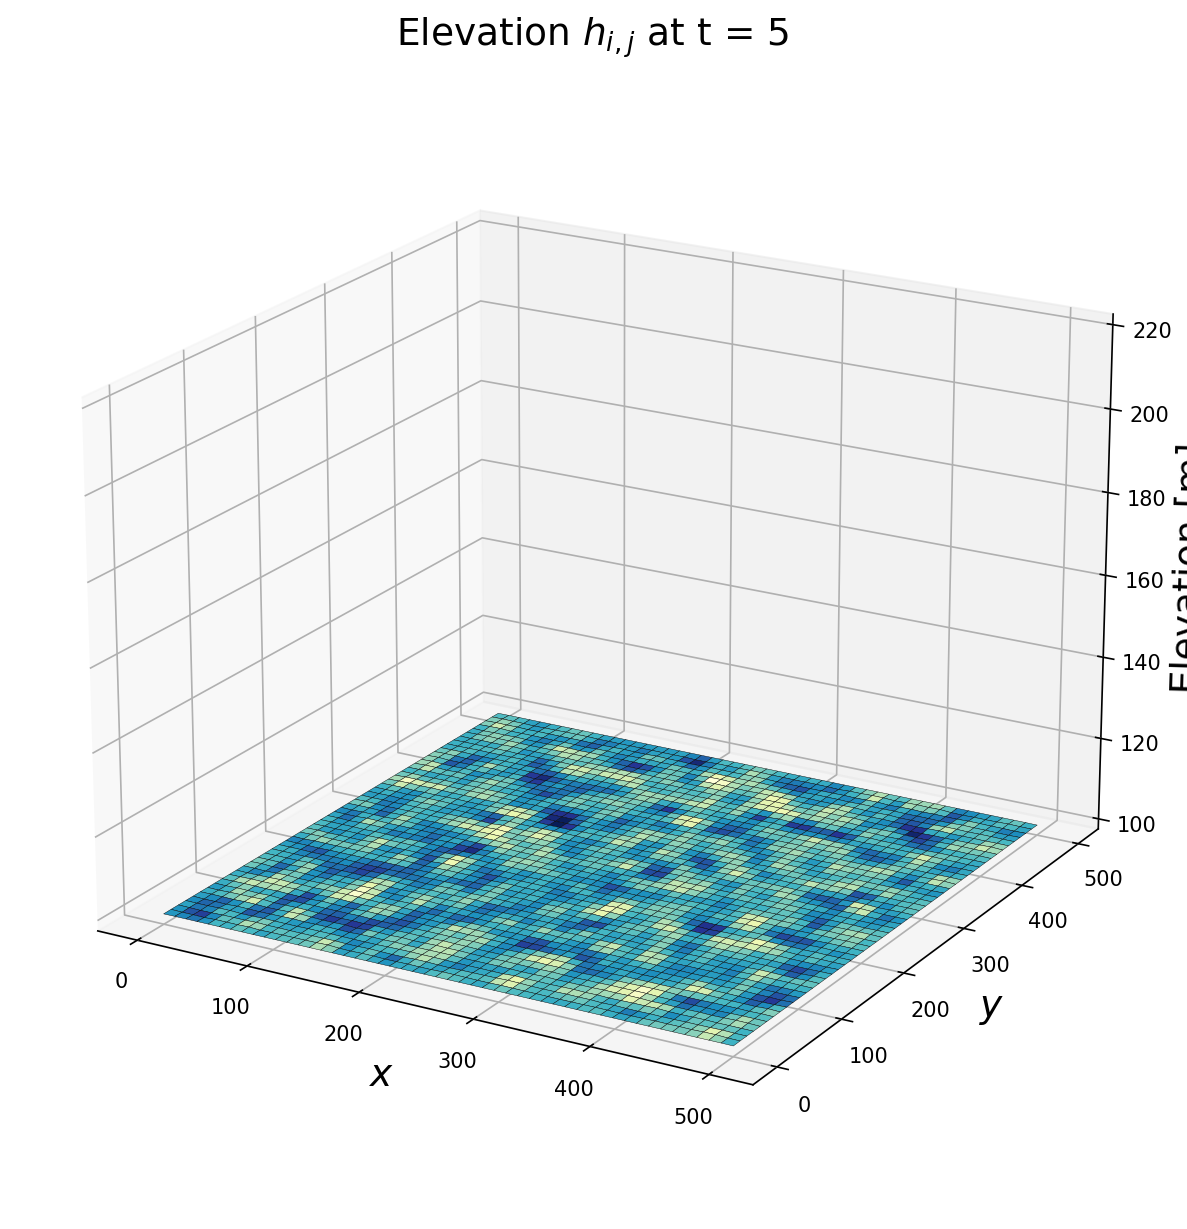

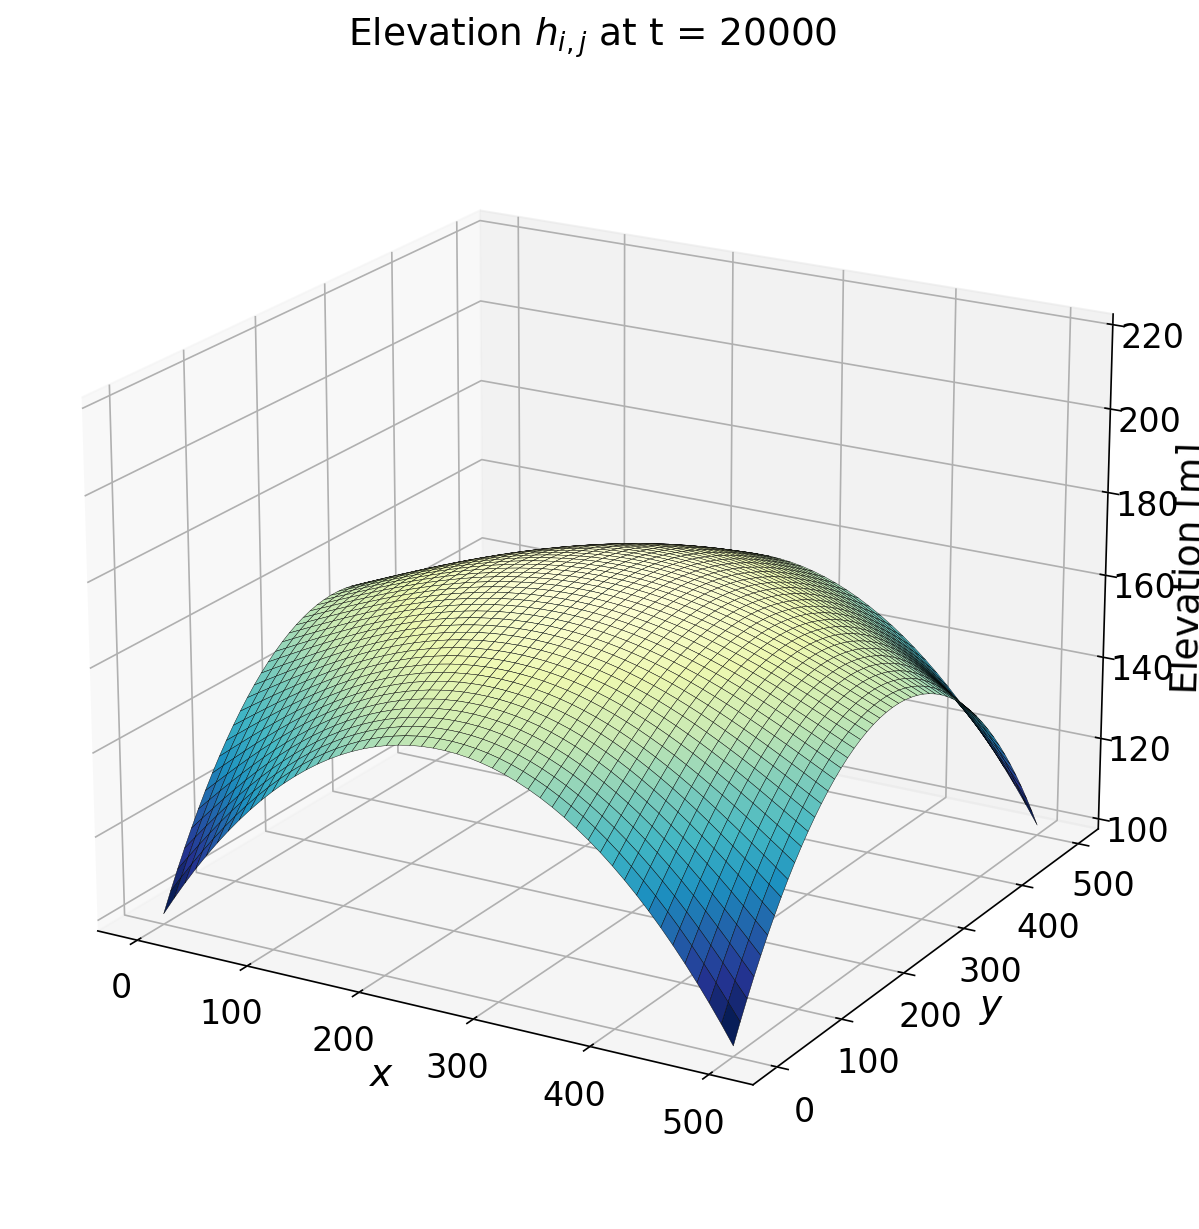

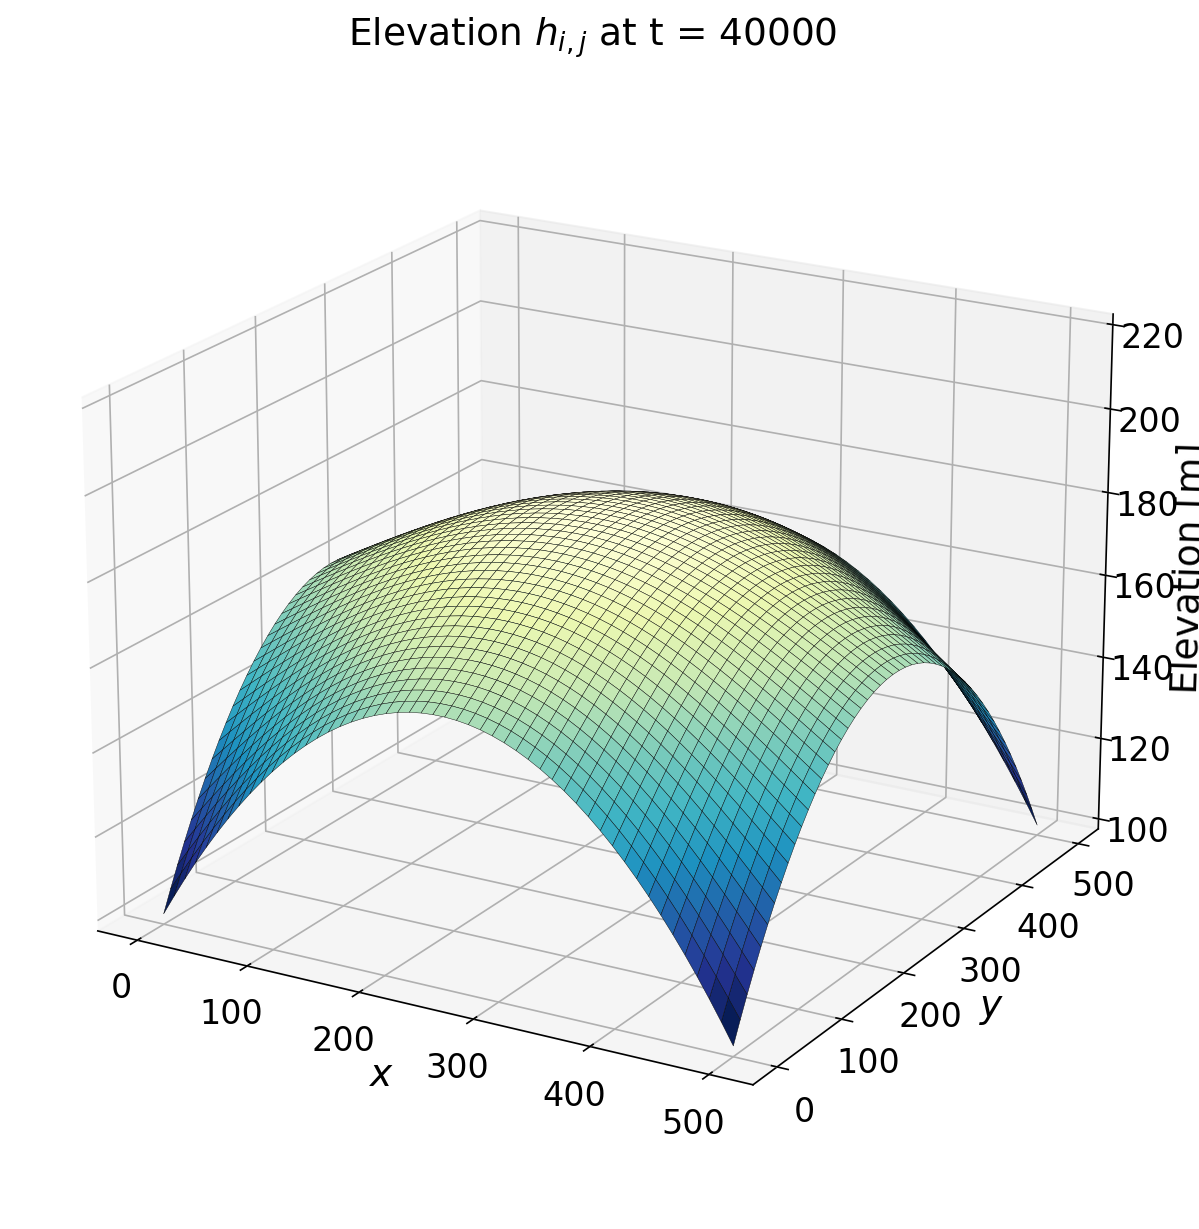

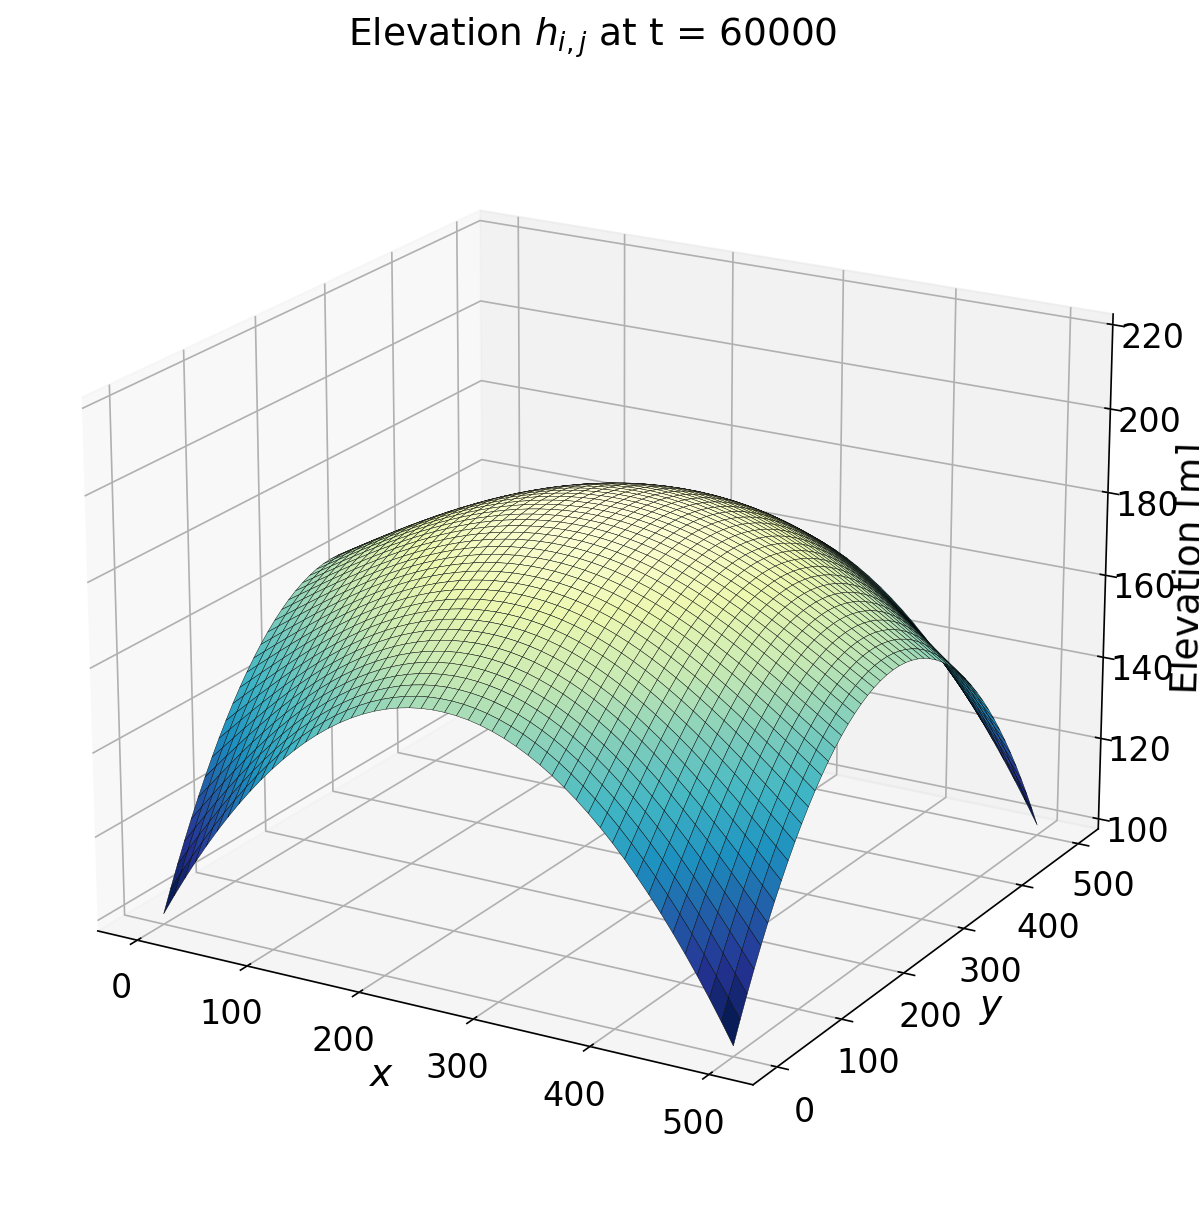

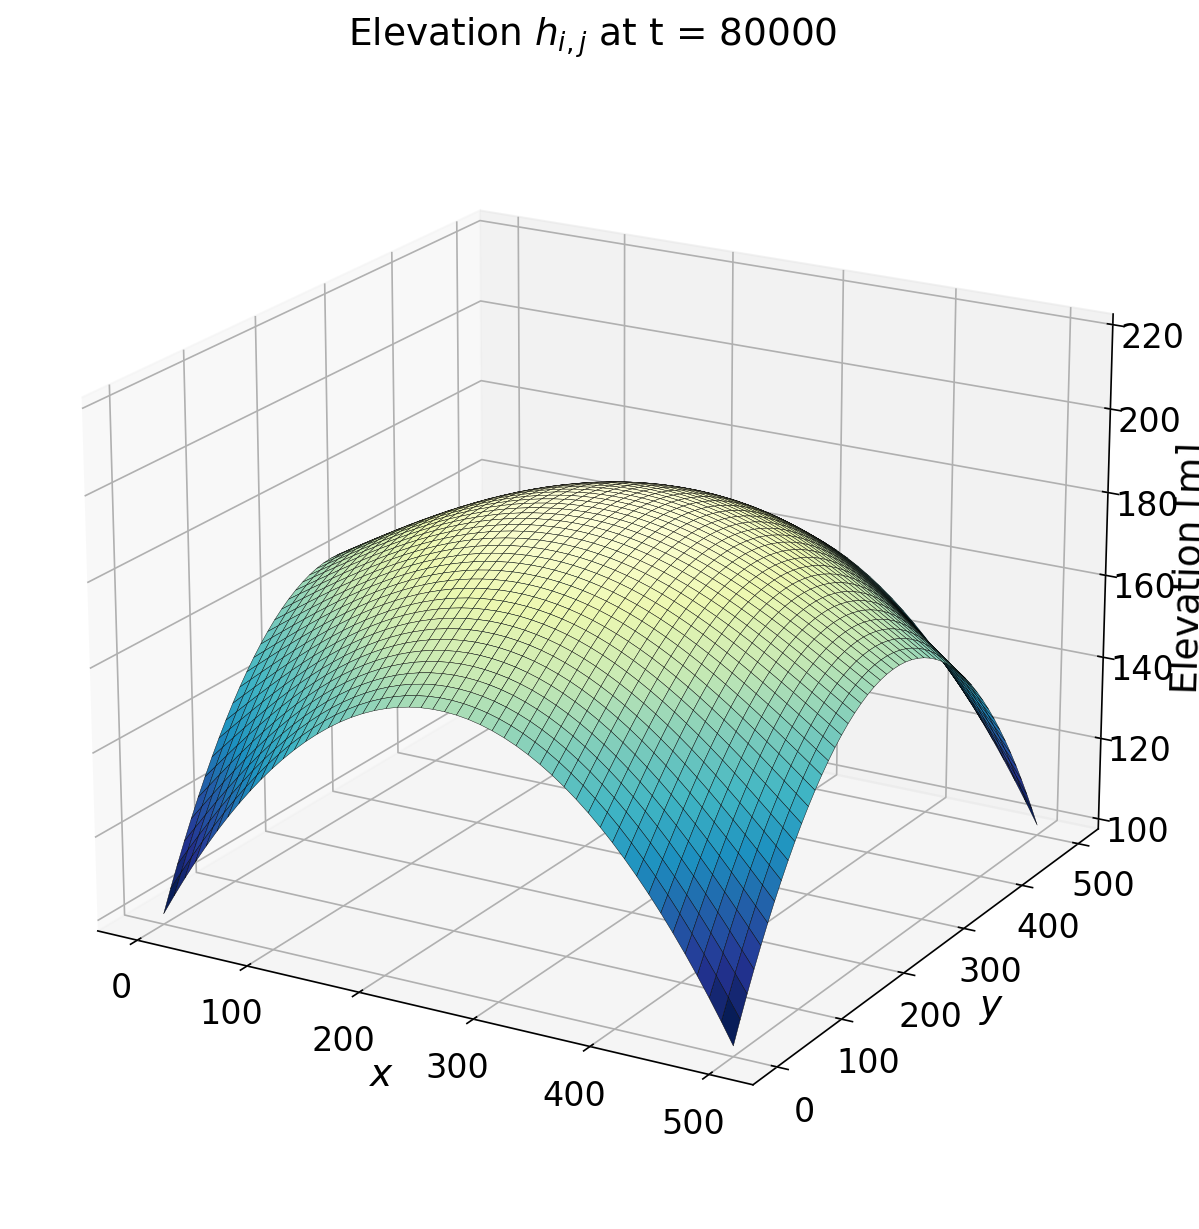

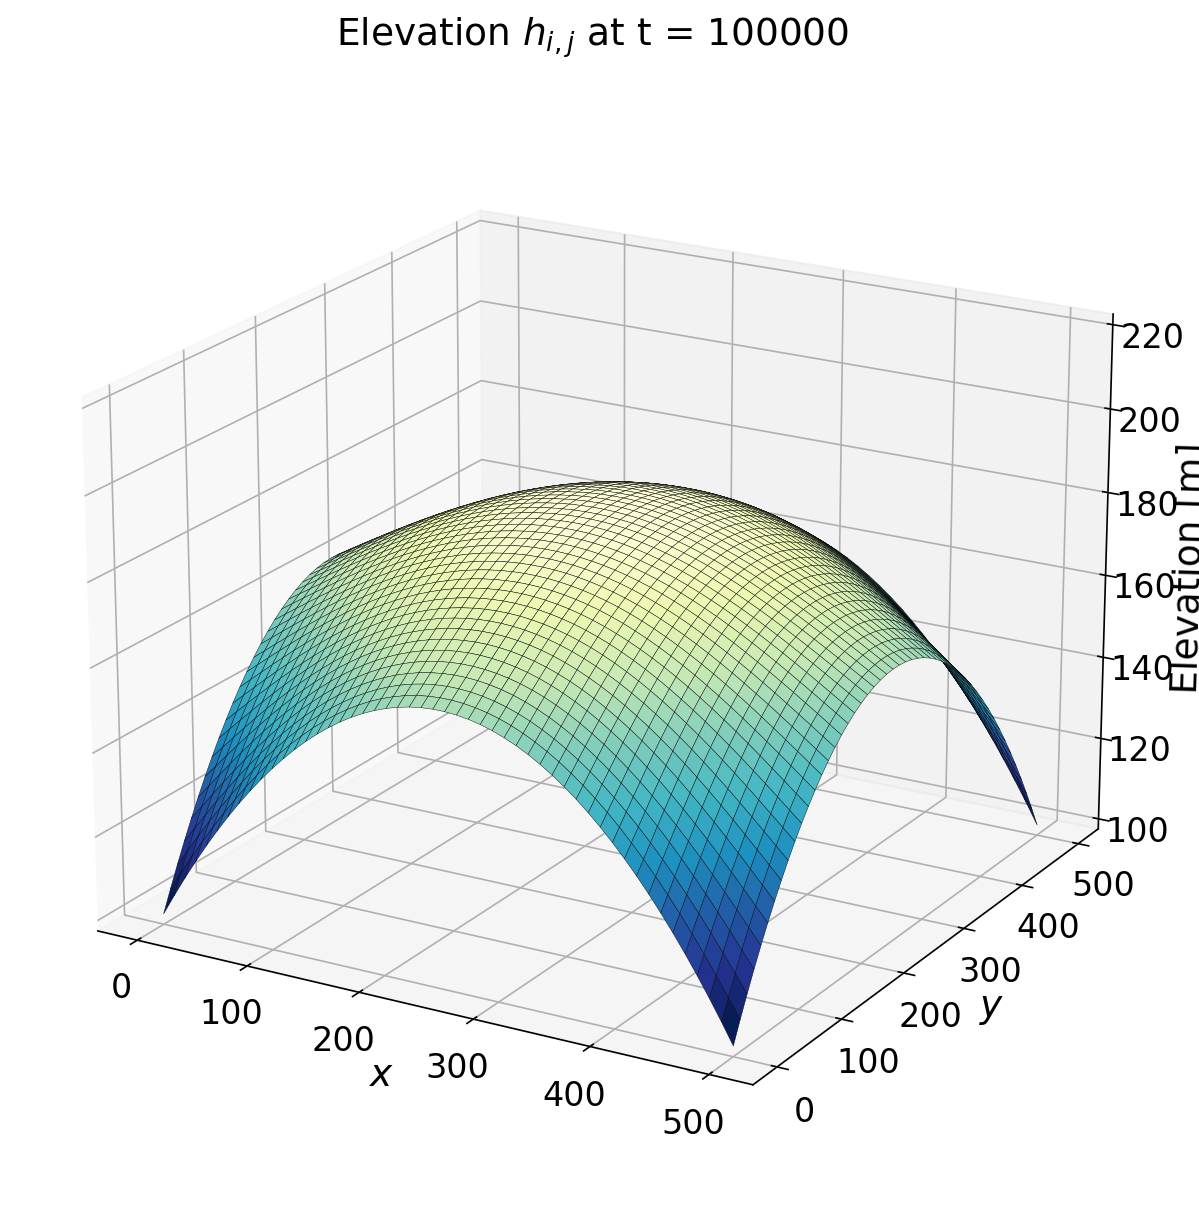

In [13]:
# EXPERIMENT 1

h0 = hi*np.ones(shape=(int(N),1)) + 0.1*np.random.randn(N,1)
hnext = np.matrix(h0)

figcounter = 1

for i in range(1,int(Nt)):
    hinit = hnext + U*dt

    hnext = hinit + alpha*Delta2*hinit

    hnext[NBound.astype(int)] = H_1D[:,i]
    hnext[EBound.astype(int)] = H_1D[:,i]
    hnext[SBound.astype(int)] = H_1D[:,i]
    hnext[WBound.astype(int)] = H_1D[:,i]
    maxArr[i-1] = hnext.max()

    if(i==1) or ((i*dt) % OutputInterval == 0):
        H = np.reshape(hnext,(Ny,Nx))

        if(individual_plots==1):
            fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(14,10), dpi=150)
            ax.set_title("Elevation $h_{i,j}$ at t = %s"%(i*dt), fontsize=18)
        else:
            if(figcounter==1):
                fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(14,10), dpi=150)
            ax.set_title('Elevation [m]', fontsize=18)
        ax.set_xlabel('$x$', fontsize=18)
        ax.set_ylabel('$y$', fontsize=18)
        ax.set_zlabel('Elevation [m]', fontsize=18)
        ax.set_xticks(np.arange(xMin,xMax+1.0,(xMax-xMin)/5))
        ax.set_yticks(np.arange(yMin,yMax+1.0,(yMax-yMin)/5))
        mpl.rcParams['xtick.labelsize'] = 16
        mpl.rcParams['ytick.labelsize'] = 16
        ax.plot_surface(X,Y,H,cmap='YlGnBu_r',linewidth=0.2,edgecolors='k')
        ax.set_zlim(hi, 220)
        # Original top Z limit : hi+U*dt*Nt
        ax.view_init(elev=20.0)
        figcounter = figcounter + 1

plt.show()

In [14]:
# TEST STATEMENT
print(H_1D)

[[100.         100.         100.         ... 100.         100.
  100.        ]
 [100.         100.025      100.04699875 ... 104.99770336 104.99770347
  104.99770357]
 [100.         100.025      100.05       ... 109.78716104 109.78716125
  109.78716146]
 ...
 [100.         100.025      100.05       ... 109.78716104 109.78716125
  109.78716146]
 [100.         100.025      100.04699875 ... 104.99770336 104.99770347
  104.99770357]
 [100.         100.         100.         ... 100.         100.
  100.        ]]


In [15]:
# TEST STATEMENT
print(maxArr)

[100.2240102  100.19787195 100.19351691 ... 188.14368405 188.14368734
   0.        ]


In [19]:
# STARTING EXPERIMENT 2 - CHANGE DIFFUSION COEFF BY 1 ORDER OF MAGNITUDE
D = 0.25 # (m^2/yr)

In [20]:
# RE-COMPUTE STABILITY VARIABLE
alpha = D*dt/dx**2
print("alpha = ",alpha)
print("dt = ",dt)
print("dx = ",dx)
if alpha >= 0.5:
    raise Exception("Stability criteria error! Either decrease dt or increase dx!")

alpha =  0.012005000000000002
dt =  5
dx =  10.204081632653061


In [21]:
# SOLVER MATRIX ALREADY CREATED

In [22]:
# SET BOUNDARY CONDITIONS
NBound = np.array(Ind[0,:])
SBound = np.array(Ind[-1,:])
WBound = np.array(Ind[:,0])
EBound = np.array(Ind[:,-1])

# Now compute the boundary conditions on the sides of the domain as the temporal evolution of a !D
# profile in response to a lowering of head on 1-side of the domain

Delta2_1D = np.matrix(np.diagflat(-2.0*np.ones((int(Nx),1)),k=0) + np.diagflat(np.ones((int(Nx-1),1)),k=1) \
    + np.diagflat(np.ones((int(Nx-1),1)),k=-1))

h0_1D = hi*np.ones(shape=(int(Nx),1))

H_1D = np.matrix(np.zeros(shape=(int(Nx),int(Nt))))

H_1D[:,0] = np.matrix(h0_1D)

for i in range(1,int(Nt)):
    hinit_1D = H_1D[:,i-1]

    hnext_1D = hinit_1D + alpha*Delta2_1D*hinit_1D + U*dt
    hnext_1D[0] = hi
    hnext_1D[-1] = hi

    H_1D[:,i] = hnext_1D[:,0]

In [23]:
individual_plots = 1

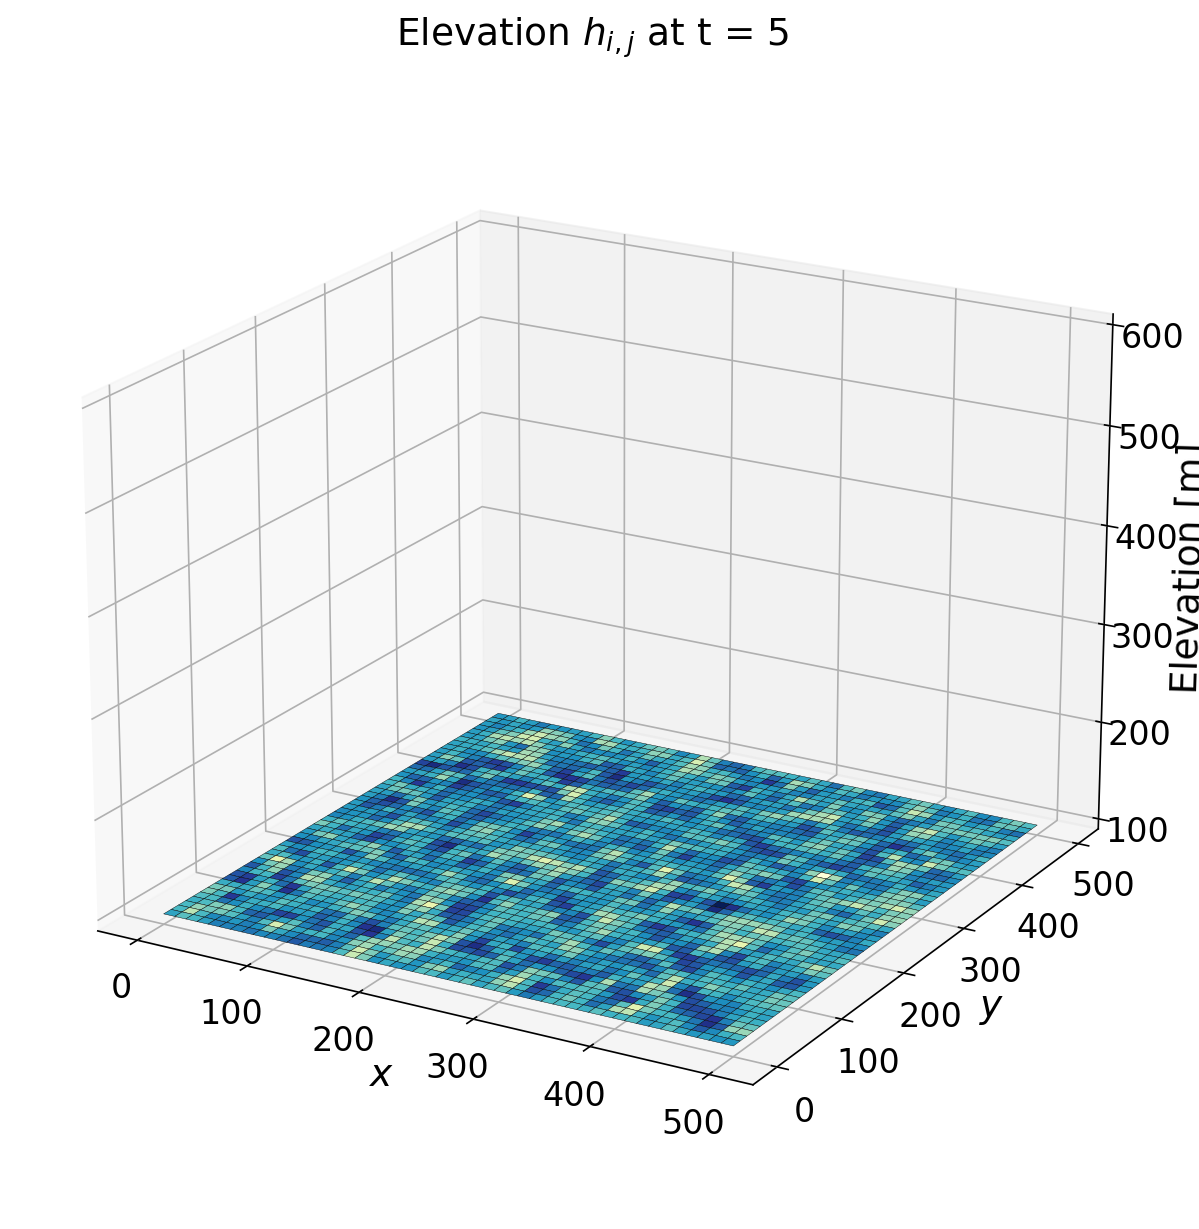

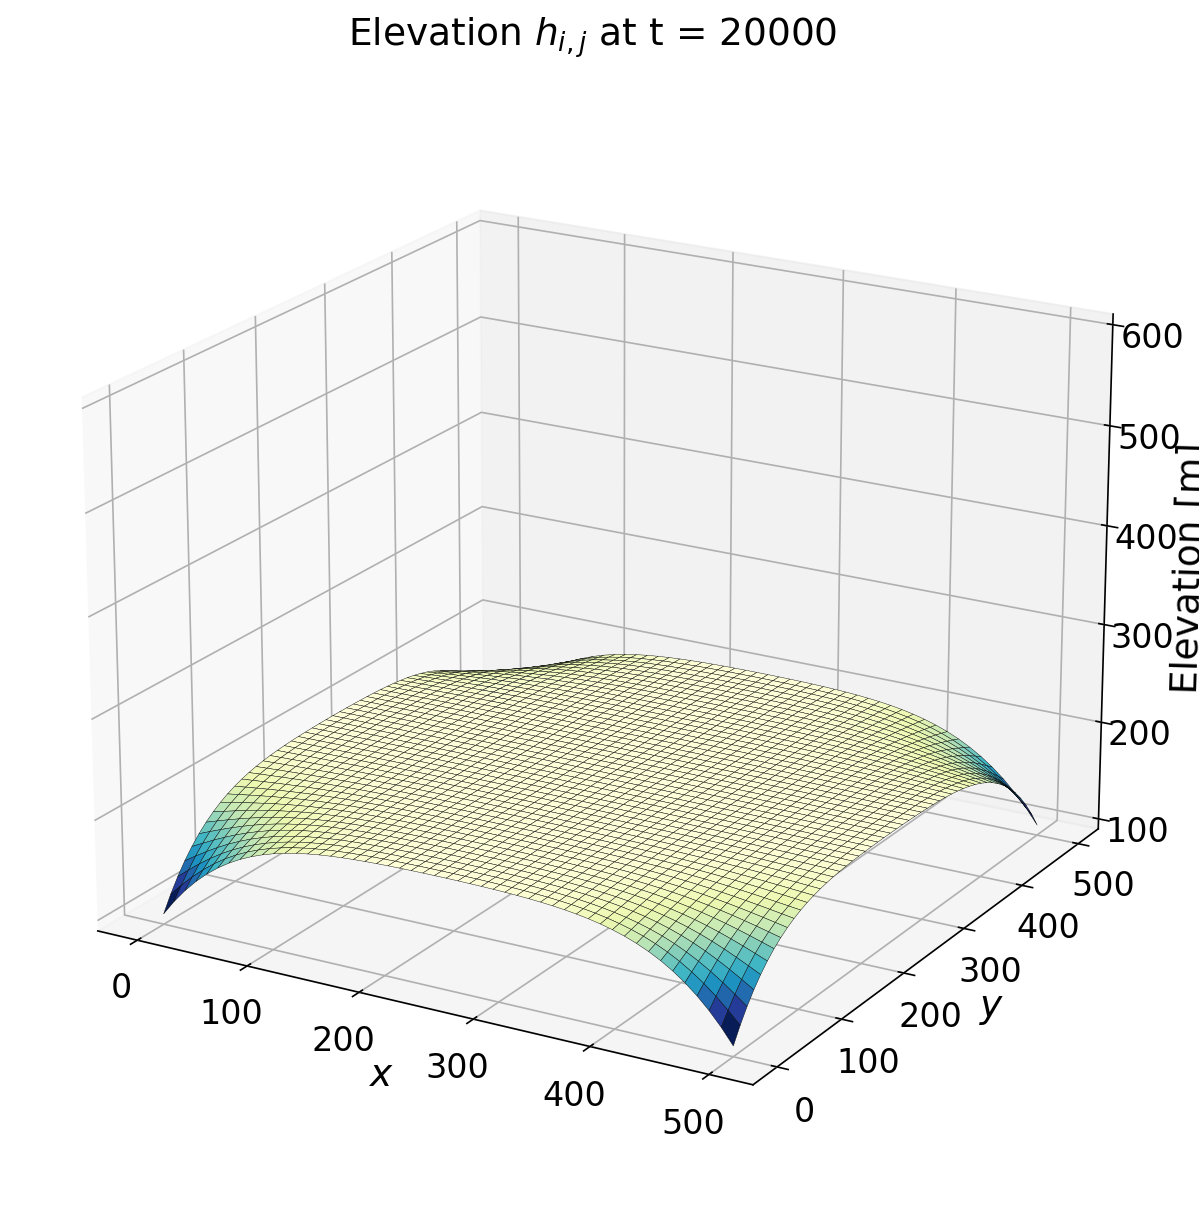

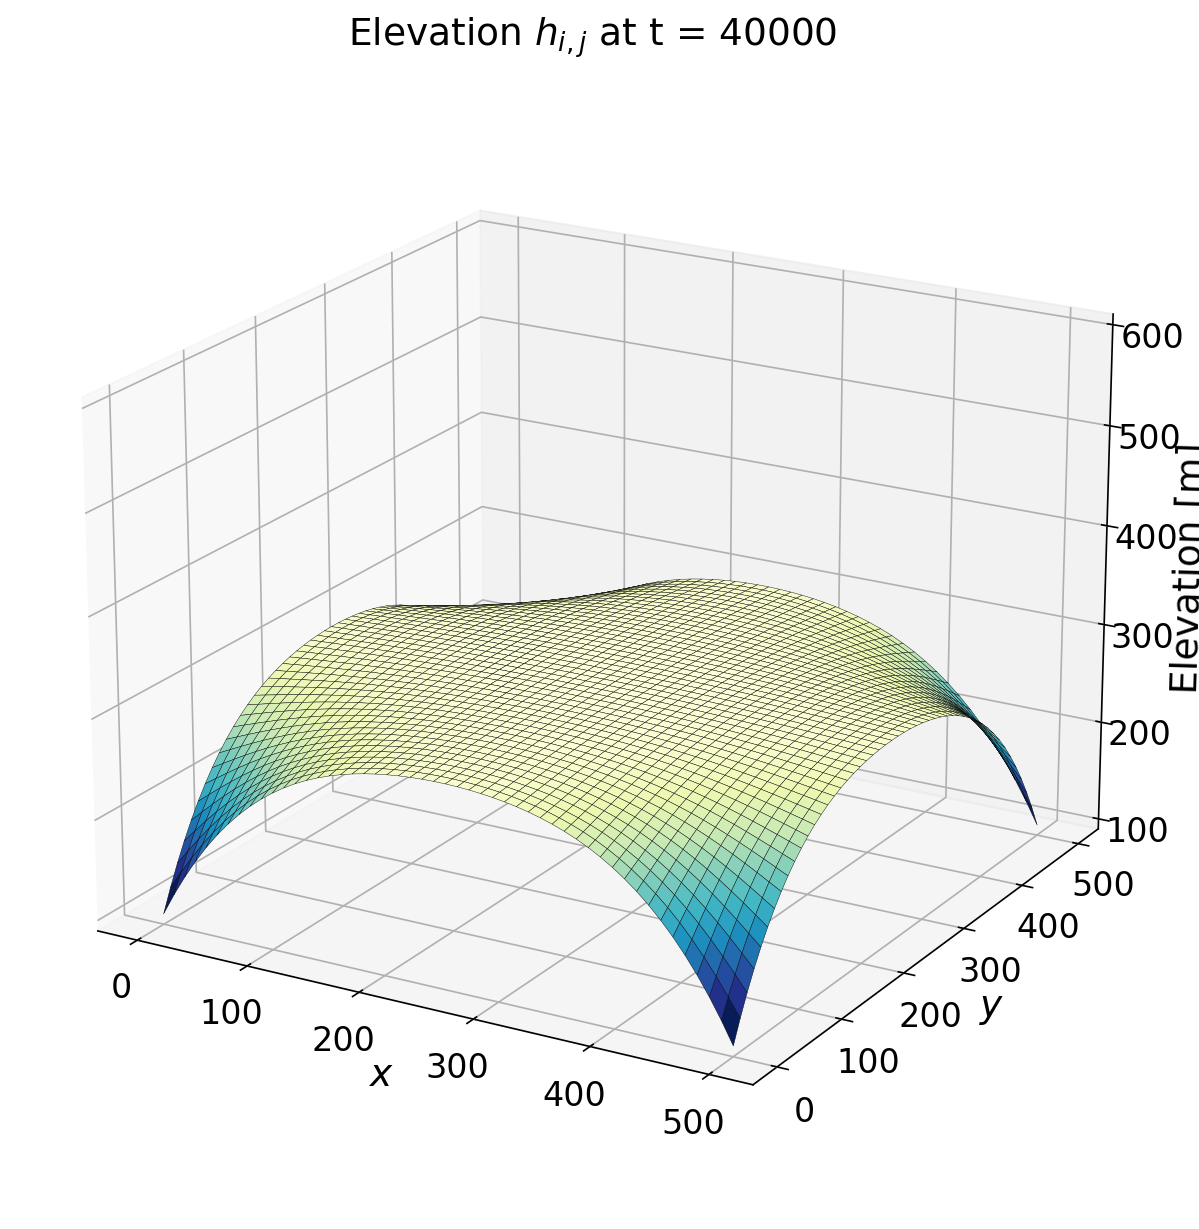

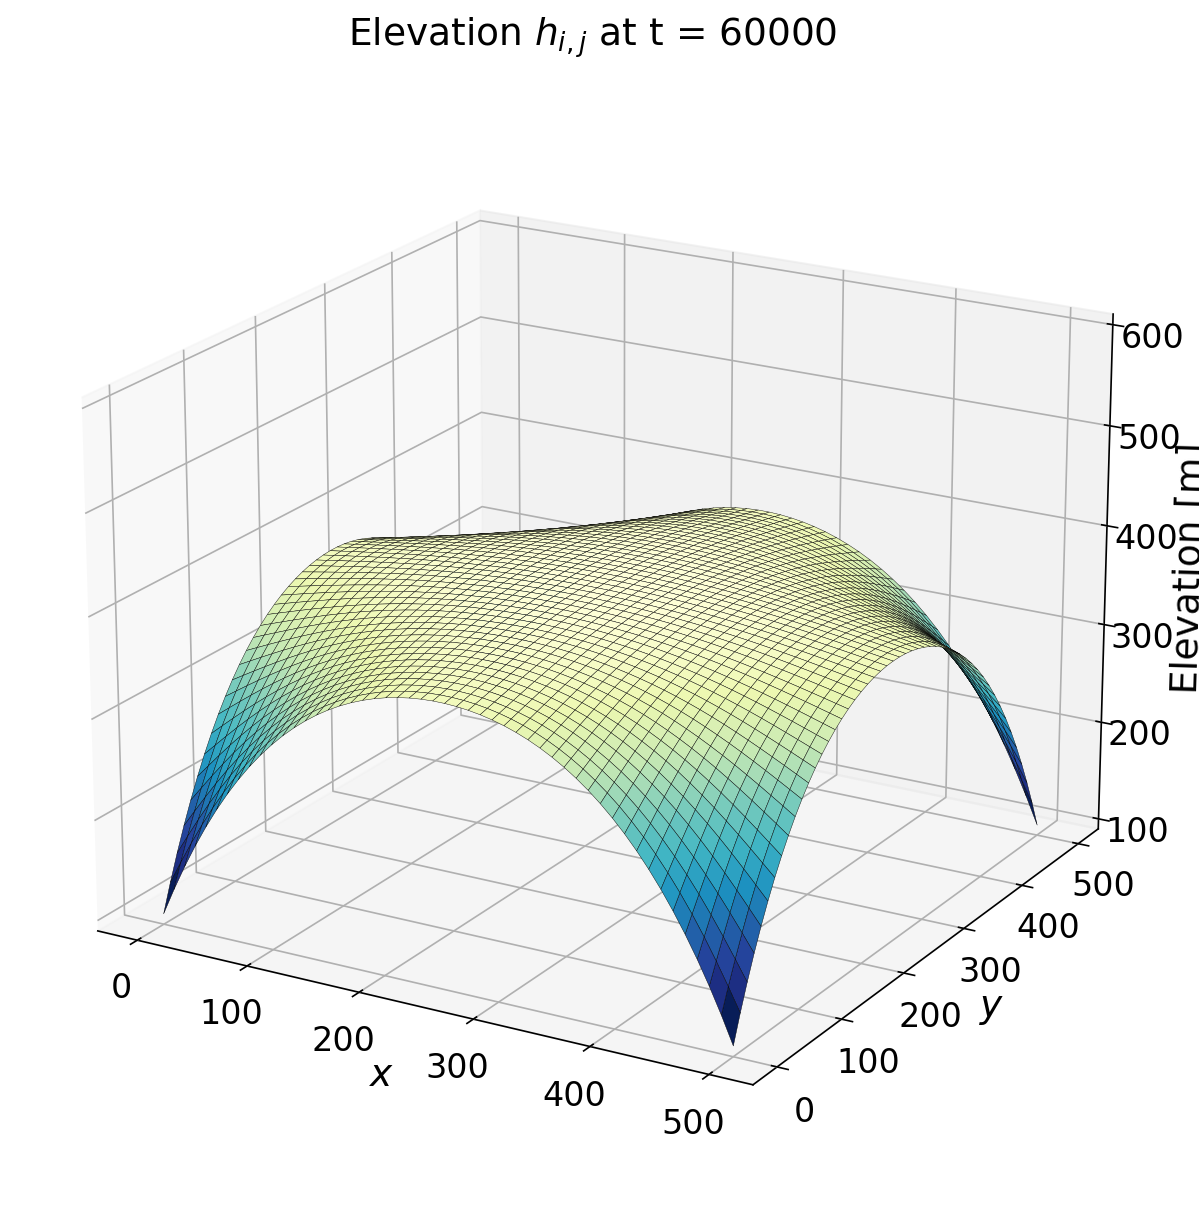

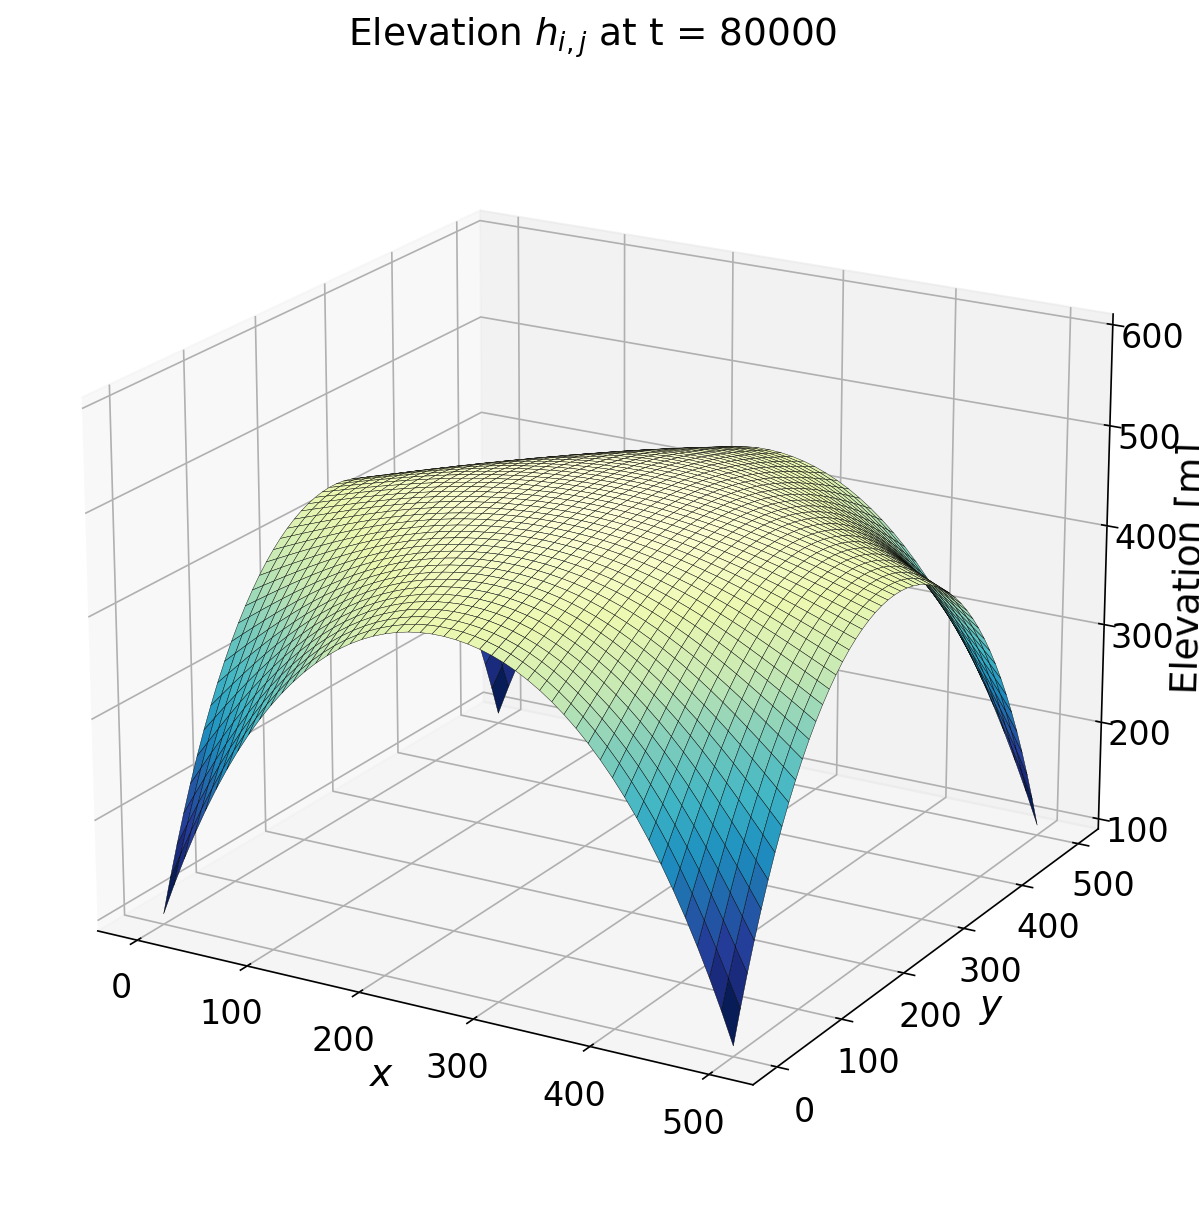

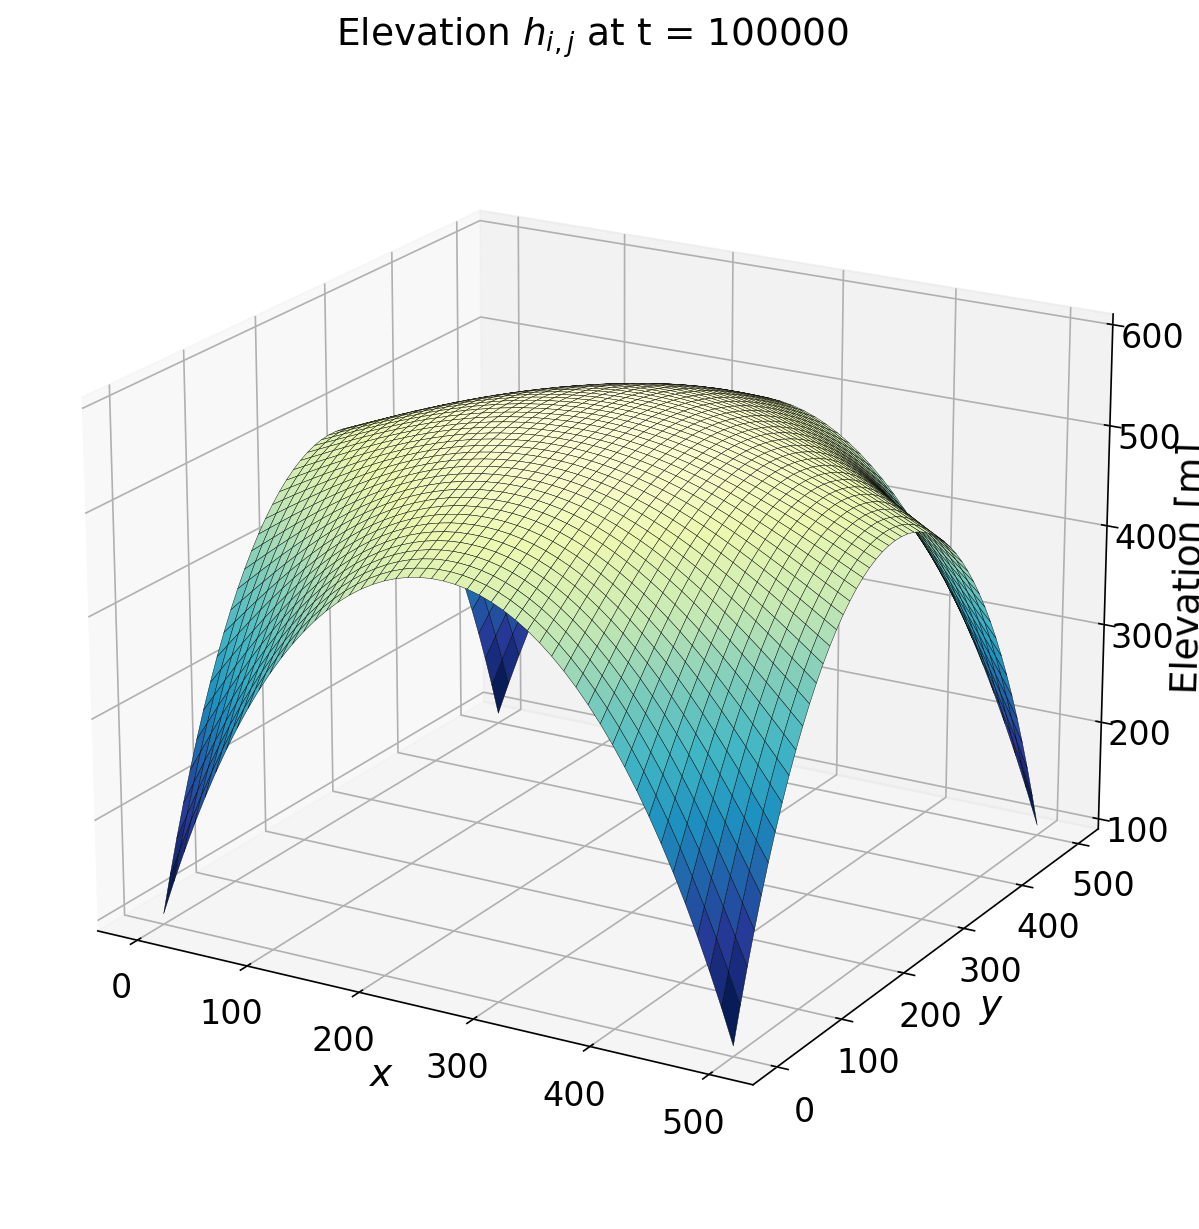

In [24]:
# EXPERIMENT 2

h0 = hi*np.ones(shape=(int(N),1)) + 0.1*np.random.randn(N,1)
hnext = np.matrix(h0)

figcounter = 1

for i in range(1,int(Nt)):
    hinit = hnext + U*dt

    hnext = hinit + alpha*Delta2*hinit

    hnext[NBound.astype(int)] = H_1D[:,i]
    hnext[EBound.astype(int)] = H_1D[:,i]
    hnext[SBound.astype(int)] = H_1D[:,i]
    hnext[WBound.astype(int)] = H_1D[:,i]
    maxArr2[i-1] = hnext.max()

    if(i==1) or ((i*dt) % OutputInterval == 0):
        H = np.reshape(hnext,(Ny,Nx))

        if(individual_plots==1):
            fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(14,10), dpi=150)
            ax.set_title("Elevation $h_{i,j}$ at t = %s"%(i*dt), fontsize=18)
        else:
            if(figcounter==1):
                fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(14,10), dpi=150)
            ax.set_title('Elevation [m]', fontsize=18)
        ax.set_xlabel('$x$', fontsize=18)
        ax.set_ylabel('$y$', fontsize=18)
        ax.set_zlabel('Elevation [m]', fontsize=18)
        ax.set_xticks(np.arange(xMin,xMax+1.0,(xMax-xMin)/5))
        ax.set_yticks(np.arange(yMin,yMax+1.0,(yMax-yMin)/5))
        mpl.rcParams['xtick.labelsize'] = 16
        mpl.rcParams['ytick.labelsize'] = 16
        ax.plot_surface(X,Y,H,cmap='YlGnBu_r',linewidth=0.2,edgecolors='k')
        ax.set_zlim(hi, hi+U*dt*Nt)
        # Original top Z limit : hi+U*dt*Nt
        ax.view_init(elev=20.0)
        figcounter = figcounter + 1

plt.show()

###

In [35]:
# TEST STATEMENT
print(maxArr)

[100.2240102  100.19787195 100.19351691 ... 188.14368405 188.14368734
   0.        ]


In [37]:
maxArr11 = maxArr[:-1]
maxArr22 = maxArr2[:-1]
print(maxArr11)

[100.2240102  100.19787195 100.19351691 ... 188.14368075 188.14368405
 188.14368734]


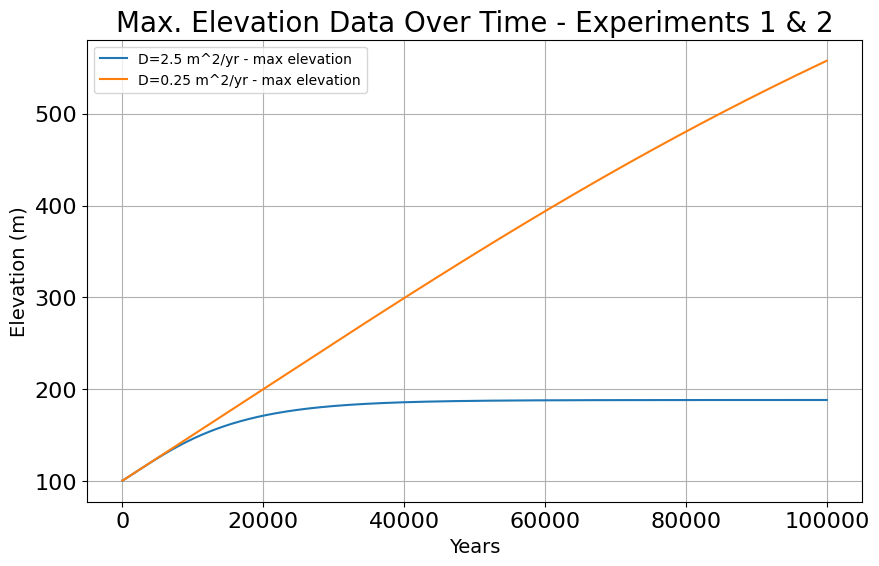

In [43]:
# CREATE META-ARRAY AND PLOT OF MAX ELEVATIONS VS. TIME
import pandas as pd
import seaborn as sns

time_steps = np.arange(ti, tf+1, dt)
time_steps1 = time_steps[:-1]
maxElev = pd.DataFrame({'Time Step': time_steps1,
                   'Elevation 1': maxArr11,
                   'Elevation 2': maxArr22})

plt.figure(figsize=(10, 6))

# Plot the data
sns.lineplot(x='Time Step', y='Elevation 1', data=maxElev, label='D=2.5 m^2/yr - max elevation')
sns.lineplot(x='Time Step', y='Elevation 2', data=maxElev, label='D=0.25 m^2/yr - max elevation')

# Customize the plot
plt.title('Max. Elevation Data Over Time - Experiments 1 & 2', fontsize=20)
plt.xlabel('Years', fontsize=14)
plt.ylabel('Elevation (m)', fontsize=14)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [46]:
'''
QUESTIONS :

1. How does changing the diffusivity change the evolution of the maximum elevation in each experiment?

2. If we were to allow Experiments 1 and 2 to run for an infinite amount of time, how would the topographic surface
between the experiments? What would be the only difference between the two topographies?
'''

'''
QUESTION 1 RESPONSE :
The change in diffusivity (decreasing by 1 order of magnitude) led to a very apparent difference in the max elevations
over time shown in the combined plot. The experiment with D=2.5 m^2/yr led to a state of stability shown in the 3-D
plots and the combined time series plot. On the other hand, the D=0.25 m^2/yr experiment did not adopt this behavior
and instead continued to exhibit soil diffusion in an almost-linear fashion for the entire test period of 100,000 years.
It may be the case that if the test period was much longer, the D=0.25 m^2/yr experiment may have reached a similar state
of stability/equilibrium as that shown in experiment 1 (at a much higher max elevation).
'''

'''
QUESTION 2 RESPONSE :
Expanding upon the comment on future stability/equilibrium in the Question 1 response, the downward curvature of the D=0.25 m^2/yr
graph of maximum elevation over time implies that the rate of diffusion should decrease and eventually result in a semi-
stable value for max elevation that ceases to change over time, like what happens in the D=2.5 m^2/yr experiment at
approximately 40,000 years and elevation ~= 188 m. At the eventual time when both experiments reach a stable value for
maximum elevation, the only difference between the topographies would be the maximum elevation and the difference between the
max and min elevation in the domain.
'''

'\nQUESTION 2 RESPONSE :\nExpanding upon the comment on future stability/equilibrium in the Question 1 response, the downward curvature of the D=0.25 m^2/yr\ngraph of maximum elevation over time implies that the rate of diffusion should decrease and eventually result in a semi-\nstable value for max elevation that ceases to change over time, like what happens in the D=2.5 m^2/yr experiment at \napproximately 40,000 years and elevation ~= 188 m. At the eventual time when both experiments reach a stable value for\nmaximum elevation, the only difference between the topographies would be the maximum elevation and the difference between the\nmax and min elevation in the domain. \n'